In [1]:
# import tensorflow as tf
# import numpy as np
# import pandas as pd
# import os
# from tensorflow.keras.layers import Rescaling

import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error

Load the training and testing data, rescale all pixels to be float vals within 0-1

In [2]:
# data_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images'
import os
import pandas as pd

data_dir = './archive'

# Define train and test directories
training_directory = os.path.join(data_dir, 'train')
testing_directory = os.path.join(data_dir, 'test')

print(training_directory)


# Get train images
train_real_images = [os.path.join(training_directory, 'REAL', img) for img in os.listdir(os.path.join(training_directory, 'REAL'))]
train_fake_images = [os.path.join(training_directory, 'FAKE', img) for img in os.listdir(os.path.join(training_directory, 'FAKE'))]

# Get test images
test_real_images = [os.path.join(testing_directory, 'REAL', img) for img in os.listdir(os.path.join(testing_directory, 'REAL'))]
test_fake_images = [os.path.join(testing_directory, 'FAKE', img) for img in os.listdir(os.path.join(testing_directory, 'FAKE'))]


# print(test_real_images[0])
# (0, 1) = (fake, real)

real_df = pd.DataFrame({'image_path': train_real_images + test_real_images,
                        'label': ["1"]*len(train_real_images) + ["1"]*len(test_real_images)}) ##60 thousand real, 0 fake

fake_df = pd.DataFrame({'image_path': train_fake_images + test_fake_images,
                        'label': ["0"]*len(train_fake_images) + ["0"]*len(test_fake_images)}) #0 real, 60 thousand fake

# real_df.head(), fake_df.head()


# Sample 80% of the rows from each DataFrame
rTrain = real_df.sample(frac=0.8, replace=False)
fTrain = fake_df.sample(frac=0.8, replace=False)

train_df = pd.concat([rTrain, fTrain])

#drops sampled from DFs
real_df = real_df.drop(rTrain.index)
fake_df = fake_df.drop(fTrain.index)

print(len(train_df)) #96,000

test_df = pd.concat([real_df, fake_df])
print(len(test_df)) ## 24,000

print(np.shape(train_df['image_path']))

print(sum(train_df['label'] == "1"))

./archive/train
96000
24000
(96000,)
48000


Now have the testing and training sets of images, need to convert images into numpy arrays to resize and greyscale them.

num of images = 96000


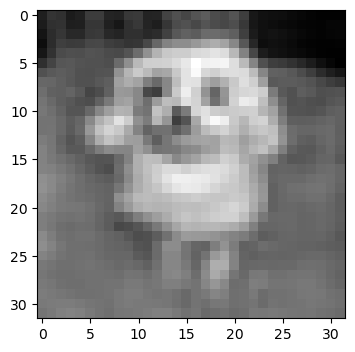

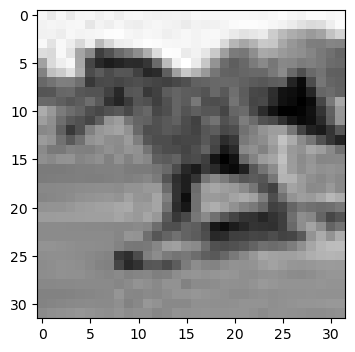

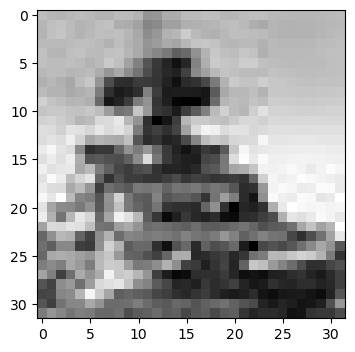

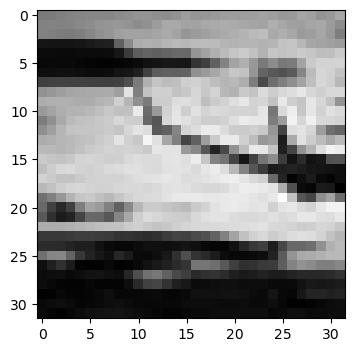

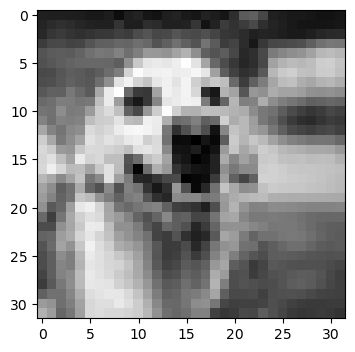

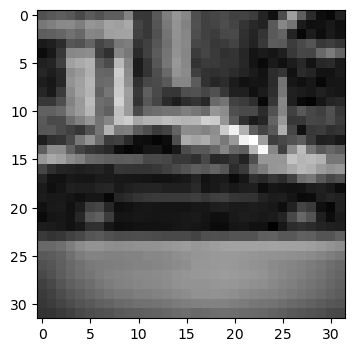

count is: 96000
(96000, 1024)
num of images = 24000


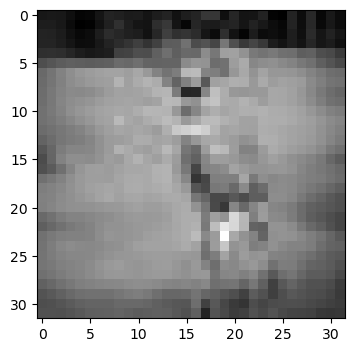

count is: 24000
(24000, 1024)


In [3]:
import matplotlib.pyplot as plt
from PIL import Image
# test_df.head()

# for training data
imgNum = 0
training_images = []
print(f"num of images = {len(train_df)}")
for filename in train_df["image_path"]:
    # print(filename)
    
    imgNum += 1
    image = plt.imread(filename)
    image = np.dot(
        image[..., :3], [0.299, 0.587, 0.114] )  #From HW3: convert 3D RGB array into 2D grayscale array (32x32)
    if ((imgNum % 15000) == 0): ## arbitrarily set to not show every image
        fig = plt.figure(figsize=(4, 4))
        plt.imshow(image, cmap="gray")
        plt.show()
    training_images.append(image.flatten())  # Flatten into a 1D vector
count = 0
for label in train_df["label"]:
    #print(label)
    count += 1
print(f"count is: {count}")

Trainfaces = np.array(training_images)
print(np.shape(Trainfaces))
#-----------------------------------------------------------------------------------------------------------------------
# For Testing Data

imgNum = 0
testing_images = []
print(f"num of images = {len(test_df)}")
for filename in test_df["image_path"]:
    # print(filename)
    
    imgNum += 1
    image = plt.imread(filename)
    image = np.dot(
        image[..., :3], [0.299, 0.587, 0.114] )  #From HW3: convert 3D RGB array into 2D grayscale array (32x32)
    if ((imgNum % 15000) == 0): ## arbitrarily set to not show every image
        fig = plt.figure(figsize=(4, 4))
        plt.imshow(image, cmap="gray")
        plt.show()
    testing_images.append(image.flatten())  # Flatten into a 1D vector
count = 0
for label in test_df["label"]:
    #print(label)
    count += 1
print(f"count is: {count}")

Testfaces = np.array(testing_images)
print(np.shape(Testfaces))




Code to Create confusion matrix from Homework

In [4]:
def creatMatrix(y_true,ypred):
    u = len(np.unique(y_true))
    confusionMatrix = np.zeros((u,u),dtype=int)
    for i in range(u):
        for j in range(u):
            ytruei = y_true==i
            ypredj = ypred==j
            count = np.sum(ytruei & ypredj) 
            confusionMatrix[i][j] = count
    return confusionMatrix

def confusion_matrix_vis(conf_matrix: np.ndarray):
    """
    Fancy print of confusion matrix. Just encapsulating some code out of the notebook.
    """
    _, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix)
    ax.set_xlabel('Predicted Labels', fontsize=16)
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('Actual Labels', fontsize=16)
    for (i, j), val in np.ndenumerate(conf_matrix):
        ax.text(j, i, str(val), ha='center', va='center', bbox=dict(
            boxstyle='round', facecolor='white', edgecolor='0.3'))
    plt.show()
    return

Adding Labels to data and then separating to X and Y arrays

In [5]:
def add_labels_to_array(list, labels):
        new = np.append(list, labels, axis = 1)
        return new
train = add_labels_to_array(Trainfaces, train_df["label"].to_numpy(dtype=int).reshape(-1, 1)) # add corresponding labels to the end of the PCA computed numpy array
test = add_labels_to_array(Testfaces, test_df["label"].to_numpy(dtype=int).reshape(-1, 1))
xtrain = train[:,:-1]
ytrain = train[:,-1]
xtest = test[:,:-1]
ytest = test[:,-1]
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)
print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape)

(96000, 1024) (96000,) (24000, 1024) (24000,)


Using 60% Retained Varience

In [ ]:
pca = PCA(n_components=0.60)
X_train = pca.fit_transform(xtrain)
X_test = pca.transform(xtest)
print(X_train.shape,X_test.shape)
clf = SVC(kernel='rbf')
clf.fit(X_train, ytrain)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy60 = accuracy_score(ytest, y_pred)

conf1 = creatMatrix(ytest, y_pred)
print("Model performance for 60% Retained Varience::")
confusion_matrix_vis(conf1)
print(f"Accuracy: {100*accuracy_score(ytest, y_pred)}%")

(96000, 9) (24000, 9)


Using 65% Retained Varience

In [ ]:
pca = PCA(n_components=0.65)
X_train = pca.fit_transform(xtrain)
X_test = pca.transform(xtest)
print(X_train.shape,X_test.shape)
clf = SVC(kernel='rbf')
clf.fit(X_train, ytrain)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy65 = accuracy_score(ytest, y_pred)

conf1 = creatMatrix(ytest, y_pred)
print("Model performance for 65% Retained Varience::")
confusion_matrix_vis(conf1)
print(f"Accuracy: {100*accuracy_score(ytest, y_pred)}%")

Using 70% Retained Varience

In [ ]:
pca = PCA(n_components=0.70)
X_train = pca.fit_transform(xtrain)
X_test = pca.transform(xtest)
print(X_train.shape,X_test.shape)
clf = SVC(kernel='rbf')
clf.fit(X_train, ytrain)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy70 = accuracy_score(ytest, y_pred)

conf1 = creatMatrix(ytest, y_pred)
print("Model performance for 70% Retained Varience::")
confusion_matrix_vis(conf1)
print(f"Accuracy: {100*accuracy_score(ytest, y_pred)}%")

Using 75% Retained Varience

In [ ]:
pca = PCA(n_components=0.75)
X_train = pca.fit_transform(xtrain)
X_test = pca.transform(xtest)
print(X_train.shape,X_test.shape)
clf = SVC(kernel='rbf')
clf.fit(X_train, ytrain)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy75 = accuracy_score(ytest, y_pred)

conf1 = creatMatrix(ytest, y_pred)
print("Model performance for 75% Retained Varience::")
confusion_matrix_vis(conf1)
print(f"Accuracy: {100*accuracy_score(ytest, y_pred)}%")

Using 80% Retained Varience

In [ ]:
pca = PCA(n_components=0.8)
X_train = pca.fit_transform(xtrain)
X_test = pca.transform(xtest)
print(X_train.shape,X_test.shape)
clf = SVC(kernel='rbf')
clf.fit(X_train, ytrain)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy80 = accuracy_score(ytest, y_pred)

conf1 = creatMatrix(ytest, y_pred)
print("Model performance for 80% Retained Varience:")
confusion_matrix_vis(conf1)
print(f"Accuracy: {100*accuracy_score(ytest, y_pred)}%")

Using 85% Retained Varience

In [ ]:
pca = PCA(n_components=0.85)
X_train = pca.fit_transform(xtrain)
X_test = pca.transform(xtest)
print(X_train.shape,X_test.shape)
clf = SVC(kernel='rbf')
clf.fit(X_train, ytrain)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy85 = accuracy_score(ytest, y_pred)

conf1 = creatMatrix(ytest, y_pred)
print("Model performance for 85% Retained Varience:")
confusion_matrix_vis(conf1)
print(f"Accuracy: {100*accuracy_score(ytest, y_pred)}%")

Using 90% Varience

In [ ]:
pca = PCA(n_components=0.90)
X_train = pca.fit_transform(xtrain)
X_test = pca.transform(xtest)
print(X_train.shape,X_test.shape)
clf = SVC(kernel='rbf')
clf.fit(X_train, ytrain)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy90 = accuracy_score(ytest, y_pred)

conf1 = creatMatrix(ytest, y_pred)
print("Model performance for 90% Retained Varience:")
confusion_matrix_vis(conf1)
print(f"Accuracy: {100*accuracy_score(ytest, y_pred)}%")

Using 95% Retained Varience

In [1]:
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(xtrain)
X_test = pca.transform(xtest)
print(X_train.shape,X_test.shape)
clf = SVC(kernel='rbf')
clf.fit(X_train, ytrain)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy95 = accuracy_score(ytest, y_pred)

conf1 = creatMatrix(ytest, y_pred)
print("Model performance for 95% Retained Varience:")
confusion_matrix_vis(conf1)
print(f"Accuracy: {100*accuracy_score(ytest, y_pred)}%")

NameError: name 'PCA' is not defined

In [ ]:
model.save("saved_models/svm.keras")

Accuracy vs Retained Varience Plot

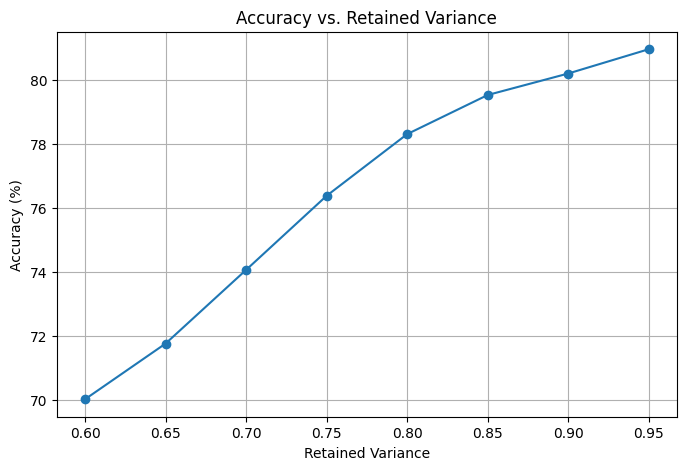

In [21]:
import matplotlib.pyplot as plt

retained_variance = [0.60, 0.65, 0.70, 0.75, 0.80, 0.85,0.90,0.95]  
accuracy_values = [accuracy60*100, accuracy65*100, accuracy70*100, accuracy75*100, accuracy80*100, accuracy85*100, accuracy90*100,accuracy95*100]  

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(retained_variance, accuracy_values, marker='o', linestyle='-')

# Labels and title
plt.xlabel('Retained Variance')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Retained Variance')
plt.grid(True)

# Show the plot
plt.show()


In [23]:
accuracyArr = [accuracy60,accuracy65,accuracy70,accuracy75,accuracy80,accuracy85,accuracy90,accuracy95]
print(accuracyArr)

[0.70025, 0.717625, 0.740625, 0.76375, 0.783, 0.7952083333333333, 0.8019166666666667, 0.8095]
